<a href="https://colab.research.google.com/github/erzar0/3D-wave-interference-simulation/blob/master/proof_of_concept_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install graphviz
!apt-get install graphviz
!pip install torchview
!nvidia-smi

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Sun Jul 21 19:12:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8          

# New Section

In [17]:
from collections import defaultdict
from functools import reduce
from functools import reduce
from graphviz import Source
from random import randint
from scipy.ndimage import gaussian_filter1d, maximum_filter1d, minimum_filter1d
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torchview import draw_graph
from torchvision import transforms, datasets
from tqdm import tqdm
import copy
import graphviz
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy.stats as stats
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm

class ElementLines():
    ELEMENT_LINES = {
        # "k": (("k_alpha", 3.314, (1**2 + 0.5**2)**0.5),       ("k_beta", 3.589, 0.11))
         "ca": (("k_alpha", 3.690, (1**2 + 0.5**2)**0.5),     ("k_beta", 4.012, 0.13))
        # , "ti": (("k_alpha", 4.508, (1**2 + 0.5**2)**0.5),     ("k_beta", 4.931, 0.15))
        # , "v": (("k_alpha", 4.948, (1**2 + 0.5**2)**0.5),     ("k_beta", 5.427, 0.15))
        # , "cr": (("k_alpha", 5.410, (1**2 + 0.5**2)**0.5),     ("k_beta", 5.946, 0.15))
        , "mn": (("k_alpha", 5.893, (1**2 + 0.5**2)**0.5),     ("k_beta", 6.490, 0.17))
        , "fe": (("k_alpha", 6.395, (1**2 + 0.5**2)**0.5),     ("k_beta", 7.058, 0.17))
        # , "co": (("k_alpha", 6.927, (1**2 + 0.51**2)**0.5),    ("k_beta", 7.649, 0.17))
        # , "ni": (("k_alpha", 7.470, (1**2 + 0.51**2)**0.5),    ("k_beta", 8.264, 0.17))
        , "cu": (("k_alpha", 8.037, (1**2 + 0.51**2)**0.5),    ("k_beta", 8.905, 0.17))
        # , "zn": (("k_alpha", 8.637, (1**2 + 0.51**2)**0.5),   ("k_beta", 9.572, 0.17))
        # , "as": (("k_alpha", 10.523, (1**2 + 0.51**2)**0.5),  ("k_beta31", 11.723, (0.06**2 + 0.13**2)**0.5))
        # , "se": (("k_alpha", 11.200, (1**2 + 0.52**2)**0.5),  ("k_beta31", 12.492, (0.06**2 + 0.13**2)**0.5))
        # , "cd": (("l_alpha", 3.130, (1**2 + 0.11**2)**0.5),   ("l_beta1", 3.316, 0.58),                       ("l_beta215", 3.528, 0.15),                     ("l_gamma", 3.716, 0.06))
        # , "sn": (("l_alpha", 3.444, (1**2 + 0.11**2)**0.5),   ("l_beta", 3.662, 0.6),                         ("l_beta215", 3.904, 0.16),                     ("l_gamma", 4.131, 0.07))
        # , "sb": (("l_alpha", 3.600, (1**2 + 0.11**2)**0.5),   ("l_beta", 3.875, (0.62**2 + 0.16**2)**0.5),    ("l_beta215", 4.100, 0.17),                     ("l_gamma", 4.347, 0.08))
        # , "au": (("l_alpha2", 9.628, 0.11),                   ("l_alpha1", 9.713, 1),                         ("l_beta1", 11.442, 0.76),                      ("l_beta2", 11.584, 0.23), ("l_gamma", 13.381, 0.13))
        , "hg": (("l_alpha2", 9.897, 0.11),                   ("l_alpha1", 9.988, 1),                         ("l_beta1", 11.824, 0.67),                      ("l_beta2", 11.924, 0.24), ("l_gamma", 13.830, 0.14))
        , "pb": (("l_alpha2", 10.449, 0.11),                  ("l_alpha1", 10.551, 1),                        ("l_beta", 12.618, (0.66**2 + 0.25**2)**0.5),   ("l_gamma", 14.764, 0.14))
        # , "bi": (("l_alpha2", 10.730, 0.11),                  ("l_alpha1", 10.838, 1),                        ("l_beta", 12.970, (0.25**2 + 0.67**2)**0.5),   ("l_gamma", 15.247, 0.14))
    }
    NUM2SYMBOL = [symbol for symbol in sorted(ELEMENT_LINES.keys())]
    SYMBOL2NUM = {symbol : i for i, symbol in enumerate(NUM2SYMBOL)}
    FANO = 5.8767709641972905
    CU_THRESHOLD_ENERGY = 8.037
    CU_ENERGY_INTENSITY_RATIO = 0.7
    ESC_THRESHOLD_ENERGY = 3
    ESCAPE_ENERGY_DIFF = 2.96
    ESCAPE_ENERGY_INTENSITY_RATIO = 0.15

    @staticmethod
    def calculate_sigma(energy):
        return np.sqrt((0.08/2.354)**2 + 0.00385 * ElementLines.FANO * energy)

    @staticmethod
    def get_parsed_element_lines(element):
        return [{"mu": line[1], "sigma": ElementLines.calculate_sigma(line[1]), "intensity": line[2], "name": f"{element}_{line[0]}"} for line in ElementLines.ELEMENT_LINES[element]]

class FeatureEnhancmentUtils():
    @staticmethod
    def reduced_dynamic_range(sample, kernel_size):
        previous_shape = sample.shape
        sample = sample.squeeze()
        max_sample = maximum_filter1d(sample, kernel_size, mode="nearest")
        min_sample = minimum_filter1d(sample, kernel_size, mode="nearest")
        max_sample = gaussian_filter1d(max_sample, kernel_size, mode="nearest")
        min_sample = gaussian_filter1d(min_sample, kernel_size, mode="nearest")

        result = (sample - min_sample) / (max_sample - min_sample)

        result[result < 0] = 0
        result[:32] = result[32]
        result[-32:] = result[-32]
        result = (result - np.min(result)) / (np.max(result) - np.min(result))
        return result.reshape(previous_shape)

    @staticmethod
    def extended_features(X):
        additional_features = np.zeros_like(X)
        for i in range(X.shape[0]):
            additional_features[i] = FeatureEnhancmentUtils.reduced_dynamic_range(X[i], 32)
        return np.concatenate((X, additional_features), axis=1)


class TrainDataGenerator():
    CHANNELS_COUNT = 4096
    TARGET_VECTOR_LENGTH = len(ElementLines.ELEMENT_LINES.keys())
    CACHED_ELEMENT_SAMPLES = {}
    MIN_ENERGY = 0
    MAX_ENERGY = 20

    @staticmethod
    def gaussian(x, mu, sigma):
        """Return Gaussian distribution values."""
        return np.exp(-(x - mu) ** 2 / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))

    @staticmethod
    def get_random_percentages(n):
        """Generate a list of random percentages that sum to 1."""
        percentages = np.random.uniform(0, 1, n)
        return percentages / np.sum(percentages)

    @staticmethod
    def sample_elements(elements_count, selected_elements=None):
        """Sample a given number of elements."""
        if selected_elements is None:
            return random.sample(list(ElementLines.ELEMENT_LINES.keys()), elements_count)
        return [el if el in ElementLines.ELEMENT_LINES.keys() else ElementLines.NUM2SYMBOL[el] for el in selected_elements]

    @staticmethod
    def add_escape_peak(energy_range, element_line, element_sample, mu_err_global, mu_max_err, sigma_max_err, scale_sigma):
        """Add escape peak to the element sample if conditions are met."""
        mu_esc = element_line["mu"] - ElementLines.ESCAPE_ENERGY_DIFF + np.random.uniform(-mu_max_err, mu_max_err) + mu_err_global
        sigma = ElementLines.calculate_sigma(mu_esc) * scale_sigma + np.random.uniform(-sigma_max_err, sigma_max_err)
        intensity = element_line["intensity"] * ElementLines.ESCAPE_ENERGY_INTENSITY_RATIO
        gaussian = TrainDataGenerator.gaussian(energy_range, mu_esc, sigma)
        gaussian /= np.max(gaussian)
        gaussian *= intensity
        element_sample += gaussian
        return element_sample

    @staticmethod
    def add_cu_peak(energy_range, element_line, element_sample, mu_err_global, mu_max_err, sigma_max_err, scale_sigma):
        """Add copper peak to the element sample if conditions are met."""
        mu_cu = ElementLines.CU_THRESHOLD_ENERGY + np.random.uniform(-mu_max_err, mu_max_err) + mu_err_global
        sigma = ElementLines.calculate_sigma(mu_cu) * scale_sigma + np.random.uniform(-sigma_max_err, sigma_max_err)
        intensity = element_line["intensity"] * ElementLines.ESCAPE_ENERGY_INTENSITY_RATIO
        gaussian = TrainDataGenerator.gaussian(energy_range, mu_cu, sigma)
        gaussian /= np.max(gaussian)
        gaussian *= intensity
        element_sample += gaussian
        return element_sample

    @staticmethod
    def _generate_element_sample(energy_range, element, mu_err_global, mu_max_err, sigma_max_err, scale_sigma, cache_element_samples):
        """Generate a sample for a single element."""
        if cache_element_samples and element in TrainDataGenerator.CACHED_ELEMENT_SAMPLES:
            return TrainDataGenerator.CACHED_ELEMENT_SAMPLES[element].copy()

        element_sample = np.zeros(TrainDataGenerator.CHANNELS_COUNT)
        for element_line in ElementLines.get_parsed_element_lines(element):
            mu = element_line["mu"] + np.random.uniform(-mu_max_err, mu_max_err) + mu_err_global
            sigma = element_line["sigma"] * scale_sigma + np.random.uniform(-sigma_max_err, sigma_max_err)
            intensity = element_line["intensity"]
            gaussian = TrainDataGenerator.gaussian(energy_range, mu, sigma)
            gaussian /= np.max(gaussian)
            gaussian *= intensity
            element_sample += gaussian

            if mu > ElementLines.ESC_THRESHOLD_ENERGY:
                element_sample = TrainDataGenerator.add_escape_peak(energy_range, element_line, element_sample, mu_err_global, mu_max_err, sigma_max_err, scale_sigma)
            if mu > ElementLines.CU_THRESHOLD_ENERGY:
                element_sample = TrainDataGenerator.add_cu_peak(energy_range, element_line, element_sample, mu_err_global, mu_max_err, sigma_max_err, scale_sigma)


        element_sample /= np.max(element_sample)

        if element not in TrainDataGenerator.CACHED_ELEMENT_SAMPLES:
            TrainDataGenerator.CACHED_ELEMENT_SAMPLES[element] = element_sample

        return element_sample

    @staticmethod
    def generate_sample(energy_range, selected_elements, element_percentages, mu_err_global, mu_max_err, sigma_max_err, scale_sigma=1, set_percentages=False, cache_element_samples=False):
        """Generate a single sample with specified elements and parameters."""
        sample = np.zeros(TrainDataGenerator.CHANNELS_COUNT)
        target = np.zeros(TrainDataGenerator.TARGET_VECTOR_LENGTH)

        for element_percentage, element in zip(element_percentages, selected_elements):
            target[ElementLines.SYMBOL2NUM[element]] = element_percentage if set_percentages else 1
            element_sample = TrainDataGenerator._generate_element_sample(energy_range, element, mu_err_global, mu_max_err, sigma_max_err, scale_sigma, cache_element_samples)
            element_sample *= element_percentage
            sample += element_sample

        sample /= np.max(sample)
        exponential = np.exp(-np.linspace(4, 5, TrainDataGenerator.CHANNELS_COUNT))
        sample += exponential
        sample /= np.max(sample)
        return sample, target

    @staticmethod
    def generate_many_samples(samples=10, elements_per_sample=3, mu_max_err=0.0, mu_max_err_global=0.0, sigma_max_err=0.0, elements=None, use_percentages=False, cache_element_samples=False):
        """Generate multiple samples with specified parameters."""
        X = [np.zeros(TrainDataGenerator.CHANNELS_COUNT) for _ in range(samples)]
        y = [np.zeros(TrainDataGenerator.TARGET_VECTOR_LENGTH) for _ in range(samples)]
        energy_range = np.linspace(TrainDataGenerator.MIN_ENERGY, TrainDataGenerator.MAX_ENERGY, TrainDataGenerator.CHANNELS_COUNT)

        for i in range(samples):
            selected_elements = TrainDataGenerator.sample_elements(elements_per_sample, elements)
            element_percentages = TrainDataGenerator.get_random_percentages(len(selected_elements))
            mu_err_global = np.random.uniform(-mu_max_err_global, mu_max_err_global)
            exponential = np.exp(-np.linspace(4, 5, TrainDataGenerator.CHANNELS_COUNT))

            sample, target = TrainDataGenerator.generate_sample(energy_range, selected_elements, element_percentages, mu_err_global, mu_max_err, sigma_max_err, scale_sigma=1, set_percentages=use_percentages, cache_element_samples=cache_element_samples)

            sample += exponential
            sample /= np.max(sample)
            X[i] = sample
            y[i] = target
        return X, y

    @staticmethod
    def generate_artificial_data(samples=10000, max_elements_per_sample=1, use_max=False, mu_max_err=0.0, mu_max_err_global=0.0, sigma_max_err=0.0, use_percentages=False, cache_element_samples=False, extended_features=False):
        max_elements_per_sample += 1
        if use_max:
            artificial_data = [TrainDataGenerator.generate_many_samples(samples=samples, elements_per_sample=max_elements_per_sample, mu_max_err=0.0, mu_max_err_global=mu_max_err_global, sigma_max_err=sigma_max_err, elements=None, use_percentages=False, cache_element_samples=True)]

        else:
            artificial_data = [TrainDataGenerator.generate_many_samples(samples=samples // max_elements_per_sample, elements_per_sample=i, mu_max_err=0.0, mu_max_err_global=mu_max_err_global, sigma_max_err=sigma_max_err, elements=None, use_percentages=False, cache_element_samples=True) for i in range(1, max_elements_per_sample)]

        X, y = reduce(lambda acc, val: (acc[0] + val[0], acc[1] + val[1]) , artificial_data, ([], []))
        X = np.asarray(X).reshape(-1, 1, TrainDataGenerator.CHANNELS_COUNT)
        y = np.asarray(y)

        if extended_features:
            X = FeatureEnhancmentUtils.extended_features(X)

        return X, y

class EvaluationUtils():
    @staticmethod
    def train(model, train_loader, valid_loader, optimizer, criterion, epochs = 3, physics_inormed_loss=False):
        best_loss = np.inf
        best_weights = None
        train_history = []
        valid_history = []
        for epoch in range(epochs):
            model.train()
            print(f"Epoch {epoch}")
            train_loss = 0
            idx = 0
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                y_pred = model(X_batch)
                if physics_inormed_loss == False:
                    loss = criterion(y_pred, y_batch)
                else:
                    loss = criterion(y_pred, y_batch, X_batch)
                loss.backward()
                optimizer.step()
                torch.cuda.empty_cache()

                idx += 1
                train_loss += float(loss)
                if idx % 10 == 0:
                    print(f"Batch {idx}, loss: {float(loss)}")

            train_loss = train_loss/idx
            print("train epoch avg loss: %.2f" % train_loss)
            train_history.append(train_loss)

            with torch.no_grad():
                model.eval()
                def _calc_loss(dataloader):
                    loss_acc = 0
                    for X_batch, y_batch in dataloader:

                        y_pred = model(X_batch)
                        if physics_inormed_loss == False:
                            loss = criterion(y_pred, y_batch)
                        else:
                            loss = criterion(y_pred, y_batch, X_batch)
                        loss_acc += float(loss)
                    return loss_acc / len(dataloader)

                valid_loss = _calc_loss(valid_loader)
                print("valid loss: %.2f" % valid_loss)
                valid_history.append(valid_loss)
                if valid_loss < best_loss:
                    best_loss = valid_loss
                    best_weights = copy.deepcopy(model.state_dict())

        return train_history, valid_history, best_loss, best_weights

    @staticmethod
    def create_dataloader(X, y, device, batch_size=16, shuffle=True):
        X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1).to(device)
        y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
        dataset = TensorDataset(X_tensor, y_tensor)
        return DataLoader(dataset, batch_size=batch_size, shuffle=True)

    @staticmethod
    def get_test_dataloader(max_elements_per_sample, device="cpu", samples=10000, use_max=False):
        return EvaluationUtils.create_dataloader(*TrainDataGenerator.generate_artificial_data(samples=samples
                                                                    , max_elements_per_sample=max_elements_per_sample
                                                                    , use_max=use_max
                                                                    , mu_max_err=0.0
                                                                    , mu_max_err_global=0.0
                                                                    , sigma_max_err=0.0
                                                                    , use_percentages=False
                                                                    , cache_element_samples=True
                                                                    , extended_features=True)
                                        , device=device
                                        , batch_size=128
                                        , shuffle=True)

    @staticmethod
    def calculate_roc(test_loader):
        pred_labels = [[] for i in range(TrainDataGenerator.TARGET_VECTOR_LENGTH)]
        real_labels = [[] for i in range(TrainDataGenerator.TARGET_VECTOR_LENGTH)]
        with torch.no_grad():
            model.eval()
            for X_batch, y_batch in test_loader:
                for y in y_batch:
                    for i, label in enumerate(y):
                        real_labels[i].append(label.to("cpu"))

                y_pred = model(X_batch)
                for y in y_pred:
                    for i, label in enumerate(y):
                        pred_labels[i].append(label.to("cpu"))

        aucs = []
        handles_list = []
        labels_list = []
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
        for i in range(TrainDataGenerator.TARGET_VECTOR_LENGTH):
            fpr, tpr, thresholds = roc_curve(real_labels[i], pred_labels[i])
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)

            line, = plt.plot(fpr, tpr)

            handles_list.append(line)
            labels_list.append(f"AUC: {roc_auc:.2f} - {ElementLines.NUM2SYMBOL[i].capitalize()}")

        sorted_lists = sorted(zip(labels_list, handles_list), key = lambda x: x[0], reverse=True)
        sorted_lists = list(zip(*sorted_lists))
        plt.legend(handles=sorted_lists[1], labels=sorted_lists[0], loc='lower right', bbox_to_anchor=(1.5, 0))
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('Receiver Operating Characteristic (ROC) Curves')
        plt.savefig("vit_equal_classes_roc.svg")

        print(f"Avg auc: {sum(aucs)/len(aucs)}")

    @staticmethod
    def calculate_accuracy_precision_recall_f1(model, test_loader):
        def _precision_recall_f1(y_true, y_pred, epsilon=1e-10):
            true_positives = torch.sum(y_true * y_pred, dim=0)
            false_positives = torch.sum((1 - y_true) * y_pred, dim=0)
            false_negatives = torch.sum(y_true * (1 - y_pred), dim=0)

            precision = true_positives / (true_positives + false_positives + epsilon)
            recall = true_positives / (true_positives + false_negatives + epsilon)

            f1 = 2 * (precision * recall) / (precision + recall + epsilon)

            precision = torch.mean(precision)
            recall = torch.mean(recall)
            f1 = torch.mean(f1)

            return precision.item(), recall.item(), f1.item()

        all_true_labels = []
        all_pred_labels = []
        all_accuracies = []
        with torch.no_grad():
            model.eval()

            for batch in test_loader:
                inputs, true_labels = batch
                outputs = model(inputs)

                pred_labels = (outputs > 0.5).float()

                accuracy = torch.mean((pred_labels == true_labels).float()).item()
                all_accuracies.append(accuracy)

                all_true_labels.append(true_labels)
                all_pred_labels.append(pred_labels)

            all_true_labels = torch.cat(all_true_labels, dim=0)
            all_pred_labels = torch.cat(all_pred_labels, dim=0)

        precision, recall, f1 = _precision_recall_f1(all_true_labels, all_pred_labels)
        accuracy = torch.mean(torch.tensor(all_accuracies)).item()

        return precision, recall, f1, accuracy

class VisionTransformer(nn.Module):
    def __init__(self, input_size, patch_size, embed_dim, num_heads, num_classes, num_layers, hidden_dim, dropout_rate):
        super(VisionTransformer, self).__init__()
        num_patches = input_size // patch_size[1]
        self.patch_embed = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        self.dropout = nn.Dropout(dropout_rate)
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, hidden_dim, dropout_rate) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim * num_patches, num_classes)
        self.gelu = nn.GELU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)
        x = self.dropout(x + self.pos_embed)
        for i, block in enumerate(self.transformer_blocks):
            x = block(x)
        x = self.norm(x)
        x = x.reshape(x.size(0), -1)

        x = self.fc(x)
        # x = self.sigmoid(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim, dropout_rate):
        super(TransformerBlock, self).__init__()

        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feedforward = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout_rate)
        )

    def forward(self, x):
        attn_output, attn_weights = self.attention(*([self.norm1(x)] * 3), need_weights=True)
        attention_weights = attn_weights
        x = x + attn_output
        x = x + self.feedforward(self.norm2(x))

        return x


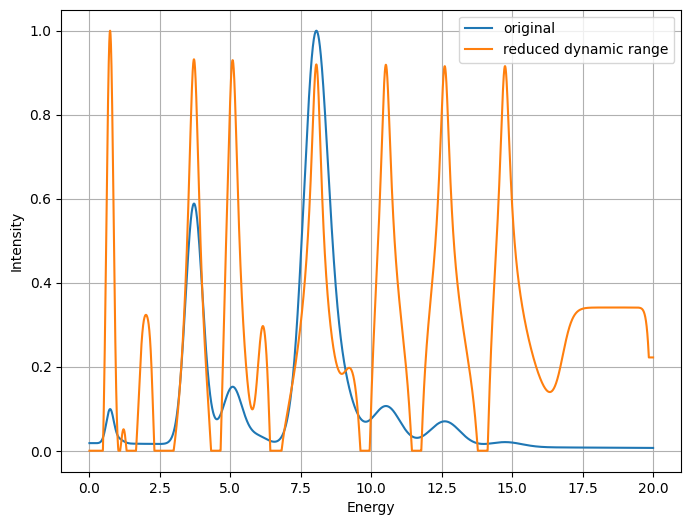

<Figure size 640x480 with 0 Axes>

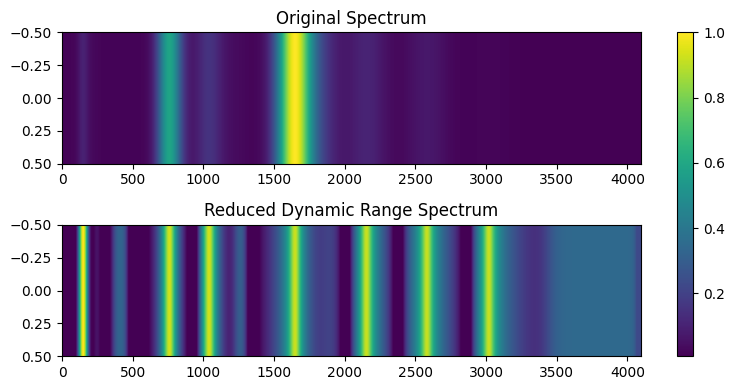

In [2]:
energy_range = np.linspace(TrainDataGenerator.MIN_ENERGY, TrainDataGenerator.MAX_ENERGY, TrainDataGenerator.CHANNELS_COUNT)
sample, target = TrainDataGenerator.generate_sample(energy_range
                                                    , selected_elements = ["ca", "cu", "pb"]
                                                    , element_percentages = [0.6, 1, 0.1]
                                                    , mu_err_global = 0
                                                    , mu_max_err = 0
                                                    , sigma_max_err = 0
                                                    , scale_sigma = 1
                                                    , set_percentages = False)

plt.figure(figsize=(8, 6))
plt.plot(energy_range, sample, label="original")
plt.plot(energy_range, FeatureEnhancmentUtils.reduced_dynamic_range(sample, 32), label="reduced dynamic range")
plt.grid(True)
plt.xlabel("Energy")
plt.ylabel("Intensity")
plt.legend()
plt.savefig("spectra_plot.svg")

plt.figure(2)

fig, ax = plt.subplots(2, 1, figsize=(8, 4))

im = ax[0].imshow(np.expand_dims(sample, axis=0), label="original", aspect="auto")
ax[0].set_title('Original Spectrum')

ax[1].imshow(np.expand_dims(FeatureEnhancmentUtils.reduced_dynamic_range(sample, 32), axis=0), label="original", aspect="auto")
ax[1].set_title('Reduced Dynamic Range Spectrum')

plt.tight_layout()
plt.colorbar(im, ax=ax)
plt.savefig("spectra_heatmaps.svg")


In [21]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 128

X, y = TrainDataGenerator.generate_artificial_data(samples=25000, max_elements_per_sample=5, mu_max_err=0.0, mu_max_err_global=0.0, sigma_max_err=0.0, use_percentages=False, cache_element_samples=True, extended_features=True)
print(X.shape)


X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.9, shuffle=True)
train_loader = EvaluationUtils.create_dataloader(X_train, y_train, DEVICE, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = EvaluationUtils.create_dataloader(X_valid, y_valid, DEVICE, batch_size=BATCH_SIZE, shuffle=True)

for X_batch, y_batch in train_loader:
    print(X_batch.shape)
    print(y_batch.shape)
    break


input_size = TrainDataGenerator.CHANNELS_COUNT
num_classes = len(ElementLines.ELEMENT_LINES.keys())
num_feature_vectors = 2
patch_width = 16
patch_size = (num_feature_vectors, patch_width)
embed_dim = 64
num_heads = 4
num_layers = 6
hidden_dim = 4 * embed_dim
dropout_rate = 0.1

model = VisionTransformer(input_size, patch_size, embed_dim, num_heads, num_classes, num_layers, hidden_dim, dropout_rate).to(DEVICE)

pytorch_total_params = sum(p.numel() for p in model.parameters())

# graph = draw_graph(model, input_size=(128, 1, 2, 4096), expand_nested=True, depth=1)
# graphviz.set_jupyter_format('png')
# graph.visual_graph

(20830, 2, 4096)
torch.Size([128, 1, 2, 4096])
torch.Size([128, 6])


In [22]:
import sys

class TrainDataGeneratorTorch():
    CHANNELS_COUNT = 4096
    TARGET_VECTOR_LENGTH = len(ElementLines.ELEMENT_LINES.keys())
    CACHED_ELEMENT_SAMPLES = {}
    MIN_ENERGY = 0
    MAX_ENERGY = 20

    @staticmethod
    def gaussian(x, mu, sigma):
        """Return Gaussian distribution values."""
        return torch.exp(-(x - mu) ** 2 / (2 * sigma ** 2)) / (sigma * torch.sqrt(torch.tensor(2 * np.pi)))

    @staticmethod
    def get_random_percentages(n):
        """Generate a list of random percentages that sum to 1."""
        percentages = torch.rand(n)
        return percentages / torch.sum(percentages)

    @staticmethod
    def sample_elements(elements_count, selected_elements=None):
        """Sample a given number of elements."""
        if selected_elements is None:
            return random.sample(list(ElementLines.ELEMENT_LINES.keys()), elements_count)
        return [el if el in ElementLines.ELEMENT_LINES.keys() else ElementLines.NUM2SYMBOL[el] for el in selected_elements]

    @staticmethod
    def add_escape_peak(energy_range, element_line, element_sample, mu_err_global, mu_max_err, sigma_max_err, scale_sigma):
        """Add escape peak to the element sample if conditions are met."""
        mu_esc = element_line["mu"] - ElementLines.ESCAPE_ENERGY_DIFF + torch.rand(1).item() * (2 * mu_max_err) - mu_max_err + mu_err_global
        sigma = ElementLines.calculate_sigma(mu_esc) * scale_sigma + torch.rand(1).item() * (2 * sigma_max_err) - sigma_max_err
        intensity = element_line["intensity"] * ElementLines.ESCAPE_ENERGY_INTENSITY_RATIO
        gaussian = TrainDataGeneratorTorch.gaussian(energy_range, mu_esc, sigma)
        gaussian = gaussian / torch.max(gaussian)
        gaussian = gaussian * intensity
        element_sample = element_sample + gaussian
        return element_sample

    @staticmethod
    def add_cu_peak(energy_range, element_line, element_sample, mu_err_global, mu_max_err, sigma_max_err, scale_sigma):
        """Add copper peak to the element sample if conditions are met."""
        mu_cu = ElementLines.CU_THRESHOLD_ENERGY + torch.rand(1).item() * (2 * mu_max_err) - mu_max_err + mu_err_global
        sigma = ElementLines.calculate_sigma(mu_cu) * scale_sigma + torch.rand(1).item() * (2 * sigma_max_err) - sigma_max_err
        intensity = element_line["intensity"] * ElementLines.ESCAPE_ENERGY_INTENSITY_RATIO
        gaussian = TrainDataGeneratorTorch.gaussian(energy_range, mu_cu, sigma)
        gaussian = gaussian / torch.max(gaussian)
        gaussian = gaussian * intensity
        element_sample = element_sample + gaussian
        return element_sample

    @staticmethod
    def _generate_element_sample(energy_range, element, mu_err_global, mu_max_err, sigma_max_err, scale_sigma, cache_element_samples, device):
        """Generate a sample for a single element."""
        if cache_element_samples and element in TrainDataGeneratorTorch.CACHED_ELEMENT_SAMPLES:
            return TrainDataGeneratorTorch.CACHED_ELEMENT_SAMPLES[element].clone().to(device)

        element_sample = torch.zeros(TrainDataGeneratorTorch.CHANNELS_COUNT)
        for element_line in ElementLines.get_parsed_element_lines(element):
            mu = element_line["mu"] + torch.rand(1).item() * (2 * mu_max_err) - mu_max_err + mu_err_global
            sigma = element_line["sigma"] * scale_sigma + torch.rand(1).item() * (2 * sigma_max_err) - sigma_max_err
            intensity = element_line["intensity"]
            gaussian = TrainDataGeneratorTorch.gaussian(energy_range, mu, sigma)
            gaussian = gaussian / torch.max(gaussian)
            gaussian = gaussian * intensity
            element_sample = element_sample + gaussian

            if mu > ElementLines.ESC_THRESHOLD_ENERGY:
                element_sample = TrainDataGeneratorTorch.add_escape_peak(energy_range, element_line, element_sample, mu_err_global, mu_max_err, sigma_max_err, scale_sigma)
            if mu > ElementLines.CU_THRESHOLD_ENERGY:
                element_sample = TrainDataGeneratorTorch.add_cu_peak(energy_range, element_line, element_sample, mu_err_global, mu_max_err, sigma_max_err, scale_sigma)

        element_sample = element_sample / torch.max(element_sample)

        if element not in TrainDataGeneratorTorch.CACHED_ELEMENT_SAMPLES:
            TrainDataGeneratorTorch.CACHED_ELEMENT_SAMPLES[element] = element_sample

        return element_sample.to(device)

    @staticmethod
    def generate_sample(energy_range, selected_elements, element_percentages, mu_err_global, mu_max_err, sigma_max_err, scale_sigma=1, set_percentages=False, cache_element_samples=False, device="cuda"):
        """Generate a single sample with specified elements and parameters."""
        sample = torch.zeros(TrainDataGeneratorTorch.CHANNELS_COUNT).to(device)
        target = torch.zeros(TrainDataGeneratorTorch.TARGET_VECTOR_LENGTH).to(device)

        for element_percentage, element in zip(element_percentages, selected_elements):
            target[ElementLines.SYMBOL2NUM[element]] = element_percentage if set_percentages else 1
            element_sample = TrainDataGeneratorTorch._generate_element_sample(energy_range, element, mu_err_global, mu_max_err, sigma_max_err, scale_sigma, cache_element_samples, device)
            element_sample = element_sample * element_percentage
            sample = sample + element_sample

        sample = sample / torch.max(sample)
        exponential = torch.exp(-torch.linspace(4, 5, TrainDataGeneratorTorch.CHANNELS_COUNT)).to(device)
        sample = sample + exponential
        sample = sample / torch.max(sample)
        return sample.to(device)

class PhysicsInformedLoss(nn.Module):
    def __init__(self, device="cpu", mse_weight=1.0, bce_weight=1.0):
        super(PhysicsInformedLoss, self).__init__()
        self.device = device
        self.mse_weight = mse_weight
        self.bce_weight = bce_weight
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCELoss()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, y_pred, y, X):
        X = X[:, :, 0, :].squeeze((1, 2))
        zero_tensor = torch.zeros_like(X).to(self.device)

        predicted_element_percentages = self.softmax(y_pred)
        artificial_spectra = torch.stack([TrainDataGeneratorTorch.generate_sample(energy_range=torch.linspace(TrainDataGenerator.MIN_ENERGY, TrainDataGenerator.MAX_ENERGY, TrainDataGenerator.CHANNELS_COUNT), selected_elements=ElementLines.NUM2SYMBOL, element_percentages=input.clone(), mu_err_global=0, mu_max_err=0, sigma_max_err=0, scale_sigma=1, set_percentages=False, cache_element_samples=True) for input in predicted_element_percentages], dim=0)
        spectra_diff = X - artificial_spectra

        bce_input = self.sigmoid(y_pred)

        # plt.plot(spectra_diff[0].cpu().detach().numpy(), label="diff")
        # plt.plot(X[0].cpu().detach().numpy(), label="X")
        # plt.plot(artificial_spectra[0].cpu().detach().numpy(), label="X_pred")
        # plt.legend()
        # sys.exit()
        mse = self.mse_loss(artificial_spectra, zero_tensor)
        bce = self.bce_loss(bce_input, y)
        return  self.bce_weight * bce + self.mse_weight * mse

In [23]:
EPOCHS = 5
optimizer = optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCELoss()
criterion = PhysicsInformedLoss(DEVICE)

torch.autograd.set_detect_anomaly(True)
train_history, valid_history, best_loss, best_weights = EvaluationUtils.train(model, train_loader, valid_loader, optimizer, criterion, epochs = EPOCHS, physics_inormed_loss=True)

model.load_state_dict(best_weights)

Epoch 0
Batch 10, loss: 1.0134975910186768
Batch 20, loss: 0.5324748754501343
Batch 30, loss: 0.1615060269832611
Batch 40, loss: 0.14780275523662567
Batch 50, loss: 0.12832584977149963
Batch 60, loss: 0.10966867208480835
Batch 70, loss: 0.11746996641159058
Batch 80, loss: 0.0864718109369278
Batch 90, loss: 0.0901344045996666
Batch 100, loss: 0.09898997843265533
Batch 110, loss: 0.07909536361694336
Batch 120, loss: 0.06386276334524155
Batch 130, loss: 0.08639001846313477
Batch 140, loss: 0.061795320361852646
train epoch avg loss: 0.25
valid loss: 0.07
Epoch 1
Batch 10, loss: 0.10116015374660492
Batch 20, loss: 0.07532916218042374
Batch 30, loss: 0.06957106292247772
Batch 40, loss: 0.06712009757757187
Batch 50, loss: 0.07795266807079315
Batch 60, loss: 0.0924130380153656
Batch 70, loss: 0.051194120198488235
Batch 80, loss: 0.086514413356781
Batch 90, loss: 0.06004755198955536
Batch 100, loss: 0.07800301909446716
Batch 110, loss: 0.061462271958589554
Batch 120, loss: 0.06239757314324379
B

<All keys matched successfully>

loss: 0.06


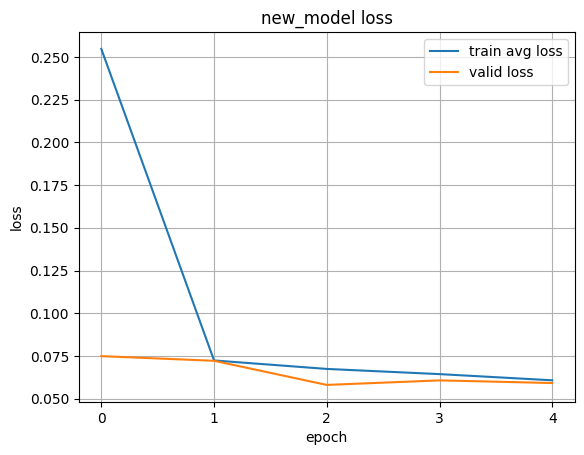

In [24]:
MODEL_NAME = "new_model"
torch.save(model.state_dict(), f"./{MODEL_NAME}.pt")

print("loss: %.2f" % best_loss)

plt.grid(True)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.xticks(range(len(train_history)))
plt.title(f"{MODEL_NAME} loss")
plt.plot(train_history, label="train avg loss")
plt.plot(valid_history, label="valid loss")
plt.legend()
plt.savefig(f"{MODEL_NAME}_loss.svg")

Avg auc: 0.9990911230488674


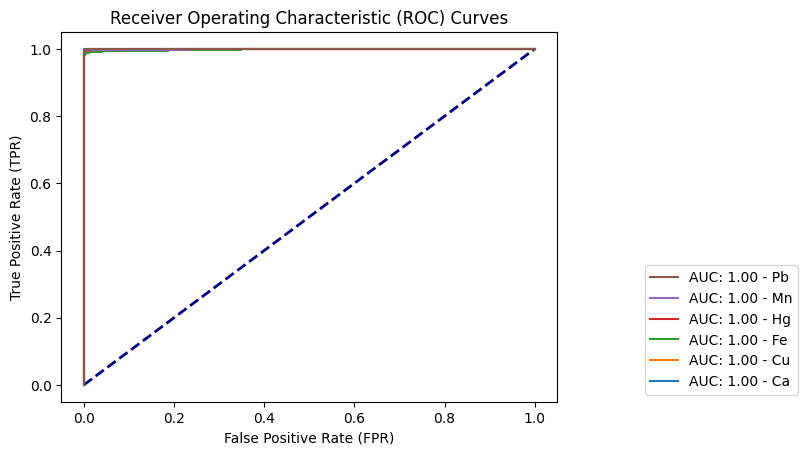

In [25]:
EvaluationUtils.calculate_roc(EvaluationUtils.get_test_dataloader(5, device=DEVICE, use_max=False))


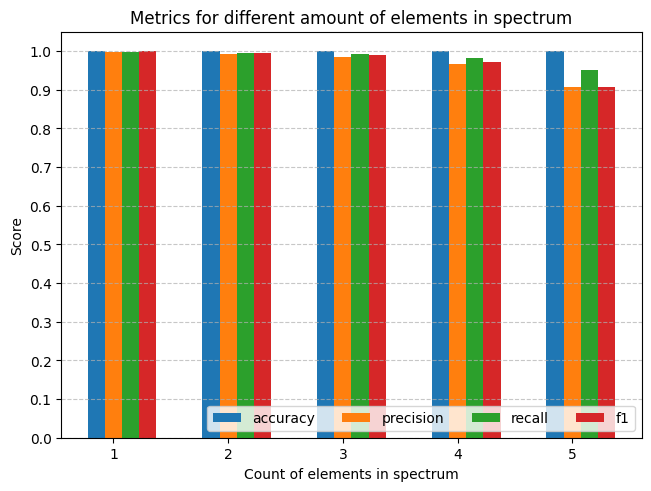

In [26]:
test_loaders = [EvaluationUtils.get_test_dataloader(i, device=DEVICE, samples=2000, use_max=True) for i in range(1, 6)]
accuracy_precision_recall_f1s = [EvaluationUtils.calculate_accuracy_precision_recall_f1(model, test_loader) for test_loader in test_loaders]

accuracy, precisions, recals, f1s = list(zip(*accuracy_precision_recall_f1s))

element_counts  = list(range(1, len(ElementLines.ELEMENT_LINES.keys())))
fig, ax = plt.subplots(constrained_layout='constrained')
ax.grid(axis='y', linestyle='--', alpha=0.7)

stats_dict = {"accuracy": accuracy, "precision": precisions, "recall": recals, "f1": f1s}

width = 0.15  # the width of the bars
multiplier = 0
x = np.arange(len(element_counts))
for attribute, measurement in stats_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

ax.set_ylabel('Score')
ax.set_xlabel('Count of elements in spectrum')
ax.set_title('Metrics for different amount of elements in spectrum')
ax.set_xticks(x + width, element_counts)
ax.set_yticks(np.linspace(0, 1, 11))
ax.legend(loc='lower right', ncols=4)
plt.savefig("vit_equal_classes_scores.svg")
